# YOLOv8 训练自己的目标检测数据集

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

本范例我们使用 torchkeras来实现对 ultralytics中的YOLOv8目标检测模型进行自定义的训练，从而检测气球。

尽管ultralytics提供了非常便捷且一致的训练API，再使用torchkeras实现自定义训练逻辑似乎有些多此一举。

但ultralytics的源码结构相对复杂，不便于用户做个性化的控制和修改。

并且，torchkeras在可视化上会比ultralytics的原生训练代码优雅许多。

不信的话，我们对比看看就明白啦。

此外，本文的内容对同学们熟悉ultralytics这个库的代码结构也会有帮助。


In [ ]:
#安装
#!pip install -U ultralytics -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
import ultralytics 
ultralytics.checks()


## 一，准备数据

公众号 算法美食屋 后台回复关键词：torchkeras，获取本文notebook代码和 balloon 数据集 下载地址。


In [1]:
%%writefile balloon.yaml
# Ultralytics YOLO 🚀, GPL-3.0 license

path: /tf/liangyun2/torchkeras/notebooks/datasets/balloon   # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: ballon


Overwriting balloon.yaml


In [2]:
import torch
from torch.utils.data import DataLoader
from ultralytics.yolo.cfg import get_cfg
from ultralytics.yolo.utils import DEFAULT_CFG,yaml_load 
from ultralytics.yolo.data.utils import check_cls_dataset, check_det_dataset
from ultralytics.yolo.data import build_yolo_dataset,build_dataloader

overrides = {'task':'detect',
             'data':'balloon.yaml',
             'imgsz':640,
             'workers':4
            }
cfg = get_cfg(cfg = DEFAULT_CFG,overrides=overrides)
data_info = check_det_dataset(cfg.data)


In [3]:
ds_train = build_yolo_dataset(cfg,img_path=data_info['train'],batch=cfg.batch,
                              data_info = data_info,mode='train',rect=False,stride=32)

ds_val = build_yolo_dataset(cfg,img_path=data_info['val'],batch=cfg.batch,data_info = data_info,
    mode='val',rect=False,stride=32)


train: Scanning /tf/liangyun2/torchkeras/notebooks/datasets/balloon/labels/train.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /tf/liangyun2/torchkeras/notebooks/datasets/balloon/labels/val.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]


In [ ]:
#dl_train = build_dataloader(ds_train,batch=cfg.batch,workers=0)
#dl_val = build_dataloader(ds_val,batch=cfg.batch,workers =0,shuffle=False)


In [4]:
dl_train = DataLoader(ds_train,batch_size = cfg.batch, num_workers = cfg.workers,
                      collate_fn = ds_train.collate_fn)

dl_val = DataLoader(ds_val,batch_size = cfg.batch, num_workers = cfg.workers,
                      collate_fn = ds_val.collate_fn)


In [5]:
for batch in dl_val:
    break 

In [6]:
batch.keys()

dict_keys(['im_file', 'ori_shape', 'resized_shape', 'ratio_pad', 'img', 'cls', 'bboxes', 'batch_idx'])

## 二，定义模型

In [46]:
from ultralytics.nn.tasks import DetectionModel

model = DetectionModel(cfg = 'yolov8n.yaml', ch=3, nc=1)
#weights = torch.hub.load_state_dict_from_url('https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt')
weights = torch.load('yolov8n.pt')
model.load(weights['model'])


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [47]:
model.args = cfg
model.nc = data_info['nc']  # attach number of classes to model
model.names = data_info['names']


## 三，训练模型

### 1，使用ultralytics原生接口

如果是使用ultralytics的原生接口，只需要以下几行代码即可。



In [57]:
from ultralytics import YOLO 
yolo_model = YOLO('yolov8n.pt')

yolo_model.train(data='balloon.yaml',epochs=10)


New https://pypi.org/project/ultralytics/8.0.112 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=balloon.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tru

AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias
train: Scanning /tf/liangyun2/torchkeras/notebooks/datasets/balloon/labels/train.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /tf/liangyun2/torchkeras/notebooks/datasets/balloon/labels/val.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
Plotting labels to runs/detect/train5/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 10 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/10      9.58G     0.7272      3.217      1.106

### 2，使用torchkeras梦中情炉

In [48]:
for batch in dl_train:
    break 

In [49]:
from ultralytics.yolo.v8.detect.train import Loss 

model.cuda()
loss_fn = Loss(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 


x = batch['img'].float()/255 

preds = model.forward(x.cuda())
loss = loss_fn(preds,batch)[0]
print(loss)


tensor(74.5465, device='cuda:0', grad_fn=<MulBackward0>)


In [52]:
from torchkeras import KerasModel 

#我们需要修改StepRunner以适应Yolov8的数据集格式

class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        features = batch['img'].float() / 255
        
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_preds = self.accelerator.gather(preds)
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


In [51]:
from tqdm import tqdm 
import sys 

class EpochRunner:
    def __init__(self,steprunner,quiet=False):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.accelerator = steprunner.accelerator
        self.net = steprunner.net
        self.quiet = quiet
        
    def __call__(self,dataloader):
        try:
            n = len(dataloader)
        except:
            n = 4 if self.steprunner.stage=='train' else 1
        loop = tqdm(enumerate(dataloader,start=1), 
                    total=n,
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols=100
                   )
        epoch_losses = {}
        for step, batch in loop: 
            with self.accelerator.accumulate(self.net):
                step_losses,step_metrics = self.steprunner(batch)   
                step_log = dict(step_losses,**step_metrics)
                for k,v in step_losses.items():
                    epoch_losses[k] = epoch_losses.get(k,0.0)+v

                if step<n:
                    loop.set_postfix(**step_log)
            
                    if hasattr(self,'progress') and self.quiet:
                        post_log = dict(**{'step':f'{step}/{n}'},**step_log)
                        self.progress.set_postfix(**post_log)

                        
                elif step==n:
                    epoch_metrics = step_metrics
                    epoch_metrics.update({self.stage+"_"+name:metric_fn.compute().item() 
                                     for name,metric_fn in self.steprunner.metrics_dict.items()})
                    epoch_losses = {k:v/step for k,v in epoch_losses.items()}
                    epoch_log = dict(epoch_losses,**epoch_metrics)
                    loop.set_postfix(**epoch_log)
                    
                    if hasattr(self,'progress') and self.quiet:
                        post_log = dict(**{'step':f'{step}/{n}'},**epoch_log)
                        self.progress.set_postfix(**post_log)
                    
                    for name,metric_fn in self.steprunner.metrics_dict.items():
                        metric_fn.reset()
                else:
                    break
        return epoch_log
    
KerasModel.EpochRunner = EpochRunner 


In [55]:
keras_model = KerasModel(net = model, 
                         loss_fn = loss_fn, 
                         optimizer = optimizer)



<<<<<< ⚡️ cuda is used >>>>>>


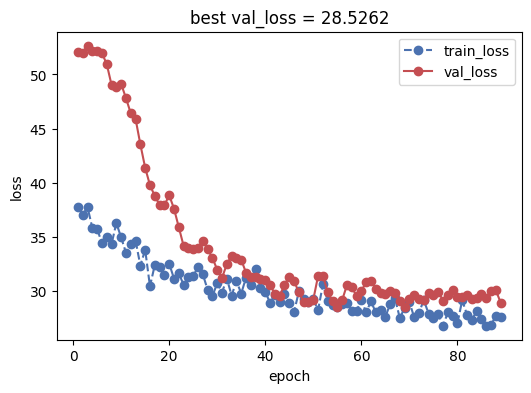

<<<<<< val_loss without improvement in 20 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,37.719327,0.0001,52.073296
1,2,37.042150,0.0001,52.000732
2,3,37.730961,0.0001,52.651379
3,4,35.827581,0.0001,52.152889
4,5,35.716244,0.0001,52.133926
...,...,...,...,...
84,85,27.393070,0.0001,29.705276
85,86,26.795735,0.0001,29.312925
86,87,26.871558,0.0001,30.020596
87,88,27.681126,0.0001,30.055944


In [56]:
keras_model.fit(train_data=dl_train,
                val_data=dl_val,
                epochs = 200,
                ckpt_path='checkpoint.pt',
                patience=20,
                monitor='val_loss',
                mode='min',
                mixed_precision='no',
                plot= True,
                wandb = False,
                quiet = True
               )


## 四，评估模型

为了便于评估 map等指标，我们将权重再次保存后，用ultralytics的原生YOLO接口进行加载后评估。


In [16]:
keras_model.evaluate(dl_val)

100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s, val_loss=28.7]


{'val_loss': 28.715129852294922}

In [17]:
from ultralytics import YOLO 
keras_model.load_ckpt('checkpoint.pt')
save_dic = dict(model = keras_model.net, train_args =dict(cfg))
torch.save(save_dic, 'best_yolo.pt')



In [19]:
from ultralytics import YOLO 
best_model = YOLO(model = 'best_yolo.pt')


In [23]:
metrics = best_model.val(data = cfg.data )


Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
val: Scanning /tf/liangyun2/torchkeras/notebooks/datasets/balloon/labels/val.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
                   all         13         50      0.919       0.74      0.852      0.732
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val6


In [24]:
metrics.results_dict


{'metrics/precision(B)': 0.9188790992746612,
 'metrics/recall(B)': 0.74,
 'metrics/mAP50(B)': 0.8516599658911874,
 'metrics/mAP50-95(B)': 0.7321355695315829,
 'fitness': 0.7440880091675434}

In [26]:
import pandas as pd 
df = pd.DataFrame()
df['metric'] = metrics.keys
for i,c in best_model.names.items():
    df[c] = metrics.class_result(i)

df 

,metric,ballon
0,metrics/precision(B),0.918879
1,metrics/recall(B),0.740000
2,metrics/mAP50(B),0.851660
3,metrics/mAP50-95(B),0.732136


## 五，使用模型


In [27]:
from pathlib import Path 
root_path = './datasets/balloon/'
data_root = Path(root_path)

best_model = YOLO(model = 'best_yolo.pt')


In [39]:
val_imgs = [str(x) for x in (data_root/'images'/'train').rglob("*.jpg") if 'checkpoint' not in str(x)]
img_path = val_imgs[5] 


In [43]:
img_path 

'datasets/balloon/images/train/1297451346_5b92bdac08_b.jpg'


image 1/1 /tf/liangyun2/torchkeras/notebooks/datasets/balloon/images/train/1297451346_5b92bdac08_b.jpg: 640x480 5 ballons, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


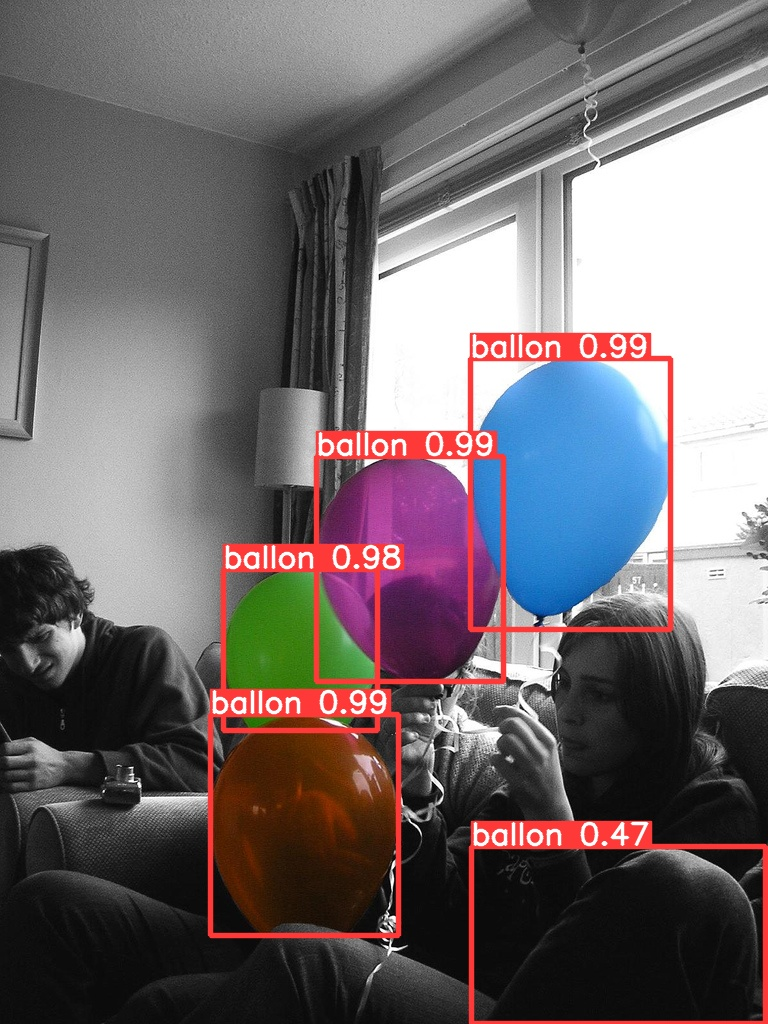

In [40]:
import os 
from PIL import Image 
result = best_model.predict(source = img_path,save=True)
best_model.predictor.save_dir/os.path.basename(img_path)
Image.open(best_model.predictor.save_dir/os.path.basename(img_path))


## 六，导出模型

Export a YOLOv8 model to any format.

Format                  | `format=...**bold text**`         | Model
---                     | ---                       | ---
PyTorch                 | -                         | yolov8n.pt
TorchScript             | `torchscript`             | yolov8n.torchscript
ONNX                    | `onnx`                    | yolov8n.onnx
OpenVINO                | `openvino`                | yolov8n_openvino_model/
TensorRT                | `engine`                  | yolov8n.engine
CoreML                  | `coreml`                  | yolov8n.mlmodel
TensorFlow SavedModel   | `saved_model`             | yolov8n_saved_model/
TensorFlow GraphDef     | `pb`                      | yolov8n.pb
TensorFlow Lite         | `tflite`                  | yolov8n.tflite
TensorFlow Edge TPU     | `edgetpu`                 | yolov8n_edgetpu.tflite
TensorFlow.js           | `tfjs`                    | yolov8n_web_model/
PaddlePaddle            | `paddle`                  | yolov8n_paddle_model/

In [30]:
best_model.export(format='onnx')

Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-2.0.0+cu117 CPU

PyTorch: starting from best_yolo.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (11.8 MB)

ONNX: starting export with onnx 1.13.0 opset 17...
ONNX: export success ✅ 0.6s, saved as best_yolo.onnx (11.7 MB)

Export complete (0.7s)
Results saved to /tf/liangyun2/torchkeras/notebooks
Predict:         yolo predict task=detect model=best_yolo.onnx imgsz=640 
Validate:        yolo val task=detect model=best_yolo.onnx imgsz=640 data=balloon.yaml 
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'best_yolo.onnx'

In [31]:
from ultralytics.yolo.v8.detect.predict import DetectionPredictor
predictor = DetectionPredictor(
    overrides=dict(model='best_yolo.onnx'))

In [32]:
results = list(predictor.stream_inference(source=img_path)) 


Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
Loading best_yolo.onnx for ONNX Runtime inference...
image 1/1 /tf/liangyun2/torchkeras/notebooks/datasets/balloon/images/train/25899693952_7c8b8b9edc_k.jpg: 640x640 1 ballon, 56.6ms
Speed: 2.3ms preprocess, 56.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train4


**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)